##  Data Overview

For this project:
1. The dataset has 1883 observations in the county where the REIT operates.
2. Each observation is for the transaction of one property only.
3. Each transaction was between $200,000 and $800,000.

#### Target Variable
* 'tx_price' - Transaction price in USD

#### Features of the data:

Public records:
* 'tx_year' - Year the transaction took place
* 'property_tax' - Monthly property tax
* 'insurance' - Cost of monthly homeowner's insurance

Property characteristics:
* 'beds' - Number of bedrooms
* 'baths' - Number of bathrooms
* 'sqft' - Total floor area in squared feet
* 'lot_size' - Total outside area in squared feet
* 'year_built' - Year property was built
* 'active_life' - Number of gyms, yoga studios, and sports venues within 1 mile
* 'basement' - Does the property have a basement?
* 'exterior_walls' - The material used for constructing walls of the house
* 'roof' - The material used for constructing the roof

Location convenience scores:
* 'restaurants' - Number of restaurants within 1 mile
* 'groceries' - Number of grocery stores within 1 mile
* 'nightlife' - Number of nightlife venues within 1 mile
* 'cafes' - Number of cafes within 1 mile
* 'shopping' - Number of stores within 1 mile
* 'arts_entertainment' - Number of arts and entertainment venues within 1 mile
* 'beauty_spas' - Number of beauty and spa locations within 1 mile
* 'active_life' - Number of gyms, yoga studios, and sports venues within 1 mile

Neighborhood demographics:
* 'median_age' - Median age of the neighborhood
* 'married' - Percent of neighborhood who are married
* 'college_grad' - Percent of neighborhood who graduated college

Schools:
* 'num_schools' - Number of public schools within district
* 'median_school' - Median score of the public schools within district, on the range 1 - 10

In [2]:
# for numerical computing
import numpy as np

# for dataframes
import pandas as pd

# for easier visualization
import seaborn as sns

# for visualization and to display plots
from matplotlib import pyplot as plt
%matplotlib inline

# import color maps
from matplotlib.colors import ListedColormap

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

from math import sqrt

# to split train and test set
from sklearn.model_selection import train_test_split

# to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import Ridge  # Linear Regression + L2 regularization
from sklearn.linear_model import Lasso  # Linear Regression + L1 regularization
from sklearn.svm import SVR # Support Vector Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as rs
from sklearn.metrics import mean_absolute_error as mae

#import xgboost
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost import XGBRegressor
from xgboost import plot_importance  # to plot feature importance

# to save the final model on disk
from sklearn.externals import joblib

Load real estate data from CSV

In [3]:
df = pd.read_csv('Files/real_estate_data.csv')

In [4]:
# Display the dimensions of the dataset.
df.shape

(1883, 26)

In [5]:
df.columns

Index(['tx_price', 'beds', 'baths', 'sqft', 'year_built', 'lot_size',
       'property_type', 'exterior_walls', 'roof', 'basement', 'restaurants',
       'groceries', 'nightlife', 'cafes', 'shopping', 'arts_entertainment',
       'beauty_spas', 'active_life', 'median_age', 'married', 'college_grad',
       'property_tax', 'insurance', 'median_school', 'num_schools', 'tx_year'],
      dtype='object')

In [6]:
# Display the first 5 rows to see example observations.
pd.set_option('display.max_columns', 20) ## display max 20 columns
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,...,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,...,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,...,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,...,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,...,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,NaN,NaN,...,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002


In [7]:
# data for s&p annual stock return
df1 = pd.read_csv('Files/stock.csv')
df1['caldt'] =  pd.to_datetime(df1['caldt'], infer_datetime_format = True)
df1['year'] = df1['caldt'].dt.year
df_new = df1.groupby('year')[['sprtrn']].mean()
df_new = df_new.reset_index()
df_new = df_new.rename(columns = {'year':'tx_year'})
df_new.head()

,tx_year,sprtrn
0,1993,0.005831
1,1994,-0.000859
2,1995,0.024858
3,1996,0.015937
4,1997,0.023728


In [8]:
# data cpi, treasury 1 year bond
df2 = pd.read_csv('Files/us.csv')
df2['caldt'] = pd.to_datetime(df2['caldt'].astype(str), format='%Y%m%d')
df2['caldt'] =  pd.to_datetime(df2['caldt'], infer_datetime_format = True)
df2['year'] = df2['caldt'].dt.year
df2 = df2[['year', 'cpiret','b1ret']]
df2 = df2.rename(columns = {'year':'tx_year'})
df2.head()

,tx_year,cpiret,b1ret
0,1993,0.027484,0.041296
1,1994,0.026749,0.023245
2,1995,0.025384,0.083992
3,1996,0.033225,0.055055
4,1997,0.017025,0.062429


In [9]:
# merge the data with stock return
df = pd.merge(df, df_new, how="outer")
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,...,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,sprtrn
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,...,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013,0.022121
1,240000,1,1,660,1983,0,Apartment / Condo / Townhouse,Brick,NaN,NaN,...,41,36.0,49.0,77.0,188.0,65.0,6.0,3.0,2013,0.022121
2,238600,1,1,834,1992,0,Apartment / Condo / Townhouse,Brick,NaN,NaN,...,20,43.0,32.0,66.0,185.0,61.0,2.0,3.0,2013,0.022121
3,371500,1,1,917,2007,0,Apartment / Condo / Townhouse,Block,Roll Composition,1.0,...,28,32.0,43.0,63.0,319.0,97.0,5.0,3.0,2013,0.022121
4,378000,1,1,961,2006,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,...,44,33.0,35.0,72.0,280.0,97.0,6.0,3.0,2013,0.022121


In [10]:
df = pd.merge(df, df2, how="outer")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1883 entries, 0 to 1882
Data columns (total 29 columns):
tx_price              1883 non-null int64
beds                  1883 non-null int64
baths                 1883 non-null int64
sqft                  1883 non-null int64
year_built            1883 non-null int64
lot_size              1883 non-null int64
property_type         1883 non-null object
exterior_walls        1660 non-null object
roof                  1529 non-null object
basement              1657 non-null float64
restaurants           1883 non-null int64
groceries             1883 non-null int64
nightlife             1883 non-null int64
cafes                 1883 non-null int64
shopping              1883 non-null int64
arts_entertainment    1883 non-null int64
beauty_spas           1883 non-null int64
active_life           1883 non-null int64
median_age            1883 non-null float64
married               1883 non-null float64
college_grad          1883 non-null float64


In [12]:
df = df.rename(columns = {'sprtrn':'s&p_returns', 'cpiret':'consumer_price_index', 'b1ret':'treasury_1_year_bond'} )


In [13]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1883 entries, 0 to 1882
Data columns (total 29 columns):
tx_price                1883 non-null int64
beds                    1883 non-null int64
baths                   1883 non-null int64
sqft                    1883 non-null int64
year_built              1883 non-null int64
lot_size                1883 non-null int64
property_type           1883 non-null object
exterior_walls          1660 non-null object
roof                    1529 non-null object
basement                1657 non-null float64
restaurants             1883 non-null int64
groceries               1883 non-null int64
nightlife               1883 non-null int64
cafes                   1883 non-null int64
shopping                1883 non-null int64
arts_entertainment      1883 non-null int64
beauty_spas             1883 non-null int64
active_life             1883 non-null int64
median_age              1883 non-null float64
married                 1883 non-null float64
coll

In [14]:
# Some feaures are numeric and some are categorical
# Filtering the categorical features:

df.dtypes[df.dtypes=='object']

property_type     object
exterior_walls    object
roof              object
dtype: object

In [15]:
# Dropping the duplicates (De-duplication)

df = df.drop_duplicates()
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,...,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,s&p_returns,consumer_price_index,treasury_1_year_bond
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,...,65.0,84.0,234.0,81.0,9.0,3.0,2013,0.022121,0.015018,0.003387
1,240000,1,1,660,1983,0,Apartment / Condo / Townhouse,Brick,NaN,NaN,...,49.0,77.0,188.0,65.0,6.0,3.0,2013,0.022121,0.015018,0.003387
2,238600,1,1,834,1992,0,Apartment / Condo / Townhouse,Brick,NaN,NaN,...,32.0,66.0,185.0,61.0,2.0,3.0,2013,0.022121,0.015018,0.003387
3,371500,1,1,917,2007,0,Apartment / Condo / Townhouse,Block,Roll Composition,1.0,...,43.0,63.0,319.0,97.0,5.0,3.0,2013,0.022121,0.015018,0.003387
4,378000,1,1,961,2006,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,...,35.0,72.0,280.0,97.0,6.0,3.0,2013,0.022121,0.015018,0.003387


In [16]:
# Fix structural errors
# The basement feature has some nan values, to handle them:

df.basement.unique()

array([nan,  1.])

In [17]:
df.basement.fillna(0, inplace=True)
df.basement.unique()

array([0., 1.])

Typos and capitalization

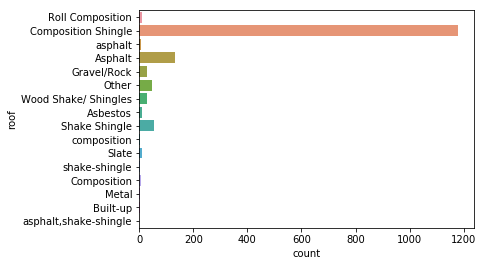

In [18]:
# Class distributions for 'roof'
sns.countplot(y='roof', data=df)

In [19]:
df.roof.replace('composition', 'Composition', inplace=True)
df.roof.replace('asphalt', 'Asphalt', inplace=True)
df.roof.replace(['shake-shingle', 'asphalt,shake-shingle'], 'Shake Shingle', inplace=True)

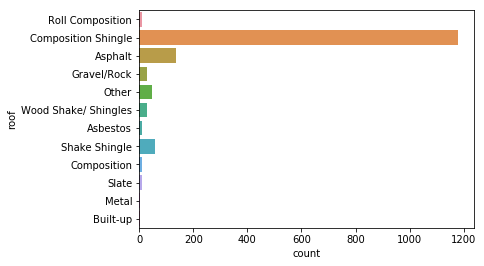

In [20]:
# Class distribution for 'roof' after the modifications
sns.countplot(y='roof', data=df)

##  Mislabeled classes
Finally, we'll check for classes that are labeled as separate classes when they should really be the same.
* e.g. If 'N/A' and 'Not Applicable' appear as two separate classes, we should combine them.
* let's plot the class distributions for 'exterior_walls':

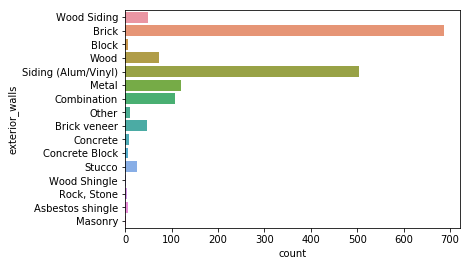

In [21]:
sns.countplot(y='exterior_walls', data=df)

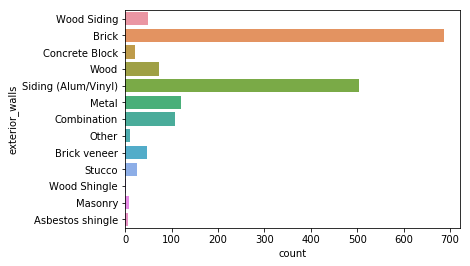

In [22]:
df.exterior_walls.replace(['Rock, Stone'], 'Masonry', inplace=True)
df.exterior_walls.replace(['Concrete', 'Block'], 'Concrete Block', inplace=True)
sns.countplot(y='exterior_walls', data=df)

## Removing Outliers
* Outliers can cause problems with certain types of models.
* Boxplots are a nice way to detect outliers
* Let's start with a box plot of your target variable, since that's what you're actually trying to predict.

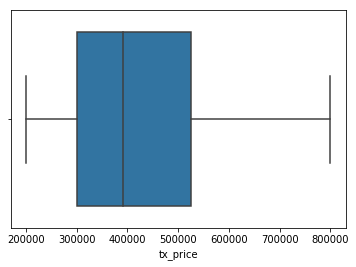

In [23]:
sns.boxplot(df.tx_price)

**Interpretation**

* The two vertical bars on the ends are the min and max values. All properties sold for between \$200,000 and \$800,000.
* The box in the middle is the interquartile range (25th percentile to 75th percentile).
* Half of all observations fall in that box.
* Finally, the vertical bar in the middle of the box is the median.

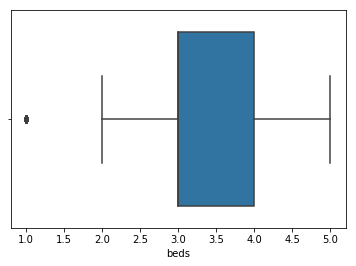

In [24]:
## Checking outliers in number of bedrooms
sns.boxplot(df.beds)

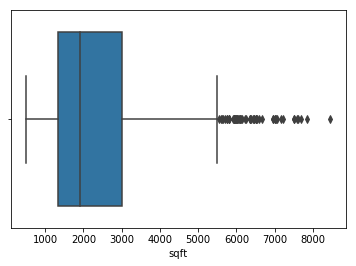

In [25]:
## Checking outliers in size of the house
sns.boxplot(df.sqft)

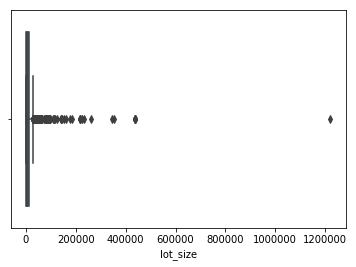

In [26]:
## Checking outliers in lot size
sns.boxplot(df.lot_size)

Look at the dot on the extreme right. This might indicate some erroneous point.

Let's look at the largest 5 lot sizes just to confirm.

In [27]:
df.lot_size.sort_values(ascending=False).head()

1080    1220551
602      436471
1533     436035
1425     436035
379      435600
Name: lot_size, dtype: int64

The largest property has a lot_size of 1,220,551 sqft. The next largest has a lot_size of only 436,471 sqft.

Because it's unlikely the REIT will ever invest in properties with lots that large, and because it's the only one in the dataset, let's remove it so it doesn't interfere with our ability to model normal size properties.

In [28]:
## Remove observations with lot_size greater than 500,000 sqft.
df = df[df.lot_size <= 500000]
df.shape
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,...,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,s&p_returns,consumer_price_index,treasury_1_year_bond
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,NaN,0.0,...,65.0,84.0,234.0,81.0,9.0,3.0,2013,0.022121,0.015018,0.003387
1,240000,1,1,660,1983,0,Apartment / Condo / Townhouse,Brick,NaN,0.0,...,49.0,77.0,188.0,65.0,6.0,3.0,2013,0.022121,0.015018,0.003387
2,238600,1,1,834,1992,0,Apartment / Condo / Townhouse,Brick,NaN,0.0,...,32.0,66.0,185.0,61.0,2.0,3.0,2013,0.022121,0.015018,0.003387
3,371500,1,1,917,2007,0,Apartment / Condo / Townhouse,Concrete Block,Roll Composition,1.0,...,43.0,63.0,319.0,97.0,5.0,3.0,2013,0.022121,0.015018,0.003387
4,378000,1,1,961,2006,0,Apartment / Condo / Townhouse,Wood Siding,NaN,0.0,...,35.0,72.0,280.0,97.0,6.0,3.0,2013,0.022121,0.015018,0.003387


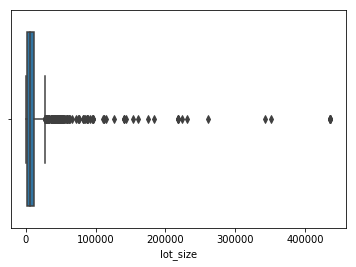

In [29]:
## Plotting the boxplot of lot size after the change
sns.boxplot(df.lot_size)

Note: Even though visually the plot looks the same but the x-axis dimensions have changed

### Label missing categorical data
You cannot simply ignore missing values in your dataset. You must handle them in some way for the very practical reason that Scikit-Learn algorithms do not accept missing values.

In [30]:
# Display number of missing values by categorical feature
df.select_dtypes(include=['object']).isnull().sum()

property_type       0
exterior_walls    223
roof              353
dtype: int64

#### The best way to handle missing data for categorical features is to simply label them as 'Missing'

In [31]:
df['exterior_walls'] = df['exterior_walls'].fillna('Missing')
df['roof'] = df['roof'].fillna('Missing')
df.select_dtypes(include=['object']).isnull().sum()

property_type     0
exterior_walls    0
roof              0
dtype: int64

In [37]:
df.columns

Index(['tx_price', 'beds', 'baths', 'sqft', 'year_built', 'lot_size',
       'property_type', 'exterior_walls', 'roof', 'basement', 'restaurants',
       'groceries', 'nightlife', 'cafes', 'shopping', 'arts_entertainment',
       'beauty_spas', 'active_life', 'median_age', 'married', 'college_grad',
       'property_tax', 'insurance', 'median_school', 'num_schools', 'tx_year',
       's&p_returns', 'consumer_price_index', 'treasury_1_year_bond'],
      dtype='object')

In [38]:
df.corr()

,tx_price,beds,baths,sqft,year_built,lot_size,basement,restaurants,groceries,nightlife,...,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,s&p_returns,consumer_price_index,treasury_1_year_bond
tx_price,1.000000,0.383695,0.388978,0.469316,0.032426,0.181893,0.108478,-0.037815,-0.093726,0.009683,...,0.199902,0.269338,0.534935,0.532767,0.175684,-0.014197,0.109458,0.013003,0.064984,-0.095789
beds,0.383695,1.000000,0.644172,0.690812,-0.013007,0.233651,0.413720,-0.495754,-0.420821,-0.440613,...,0.642830,-0.081515,0.547330,0.485500,0.137198,-0.124134,-0.173306,0.015713,-0.049848,0.083785
baths,0.388978,0.644172,1.000000,0.681814,0.204994,0.199879,0.342625,-0.350060,-0.339179,-0.306332,...,0.441365,0.017266,0.525404,0.475124,0.163266,-0.088005,-0.131091,-0.010813,-0.049510,0.074952
sqft,0.469316,0.690812,0.681814,1.000000,0.253908,0.333195,0.269352,-0.353611,-0.370654,-0.281260,...,0.479698,0.066141,0.660064,0.593860,0.220596,-0.101832,-0.235607,0.028276,-0.018853,0.128212
year_built,0.032426,-0.013007,0.204994,0.253908,1.000000,0.029639,0.006526,-0.106610,-0.221472,-0.079468,...,0.036766,-0.013103,-0.047433,-0.110347,0.155729,-0.187894,-0.042205,-0.026312,0.039366,0.054389
lot_size,0.181893,0.233651,0.199879,0.333195,0.029639,1.000000,0.063511,-0.153891,-0.177403,-0.104721,...,0.187088,-0.062661,0.229801,0.202034,0.127544,-0.047596,-0.085535,-0.001093,-0.014495,0.055109
basement,0.108478,0.413720,0.342625,0.269352,0.006526,0.063511,1.000000,-0.456979,-0.269329,-0.516440,...,0.446015,-0.137179,0.183265,0.137853,0.004691,-0.115073,-0.068332,-0.026565,-0.052468,0.037700
restaurants,-0.037815,-0.495754,-0.350060,-0.353611,-0.106610,-0.153891,-0.456979,1.000000,0.701522,0.926673,...,-0.615667,0.214034,-0.100592,-0.019712,-0.068365,0.251092,0.044420,0.017179,0.023858,-0.002523
groceries,-0.093726,-0.420821,-0.339179,-0.370654,-0.221472,-0.177403,-0.269329,0.701522,1.000000,0.564853,...,-0.508148,-0.007026,-0.158852,-0.093396,-0.354562,0.272705,0.114772,0.017864,0.000414,-0.057656
nightlife,0.009683,-0.440613,-0.306332,-0.281260,-0.079468,-0.104721,-0.516440,0.926673,0.564853,1.000000,...,-0.568695,0.253381,-0.054028,0.024872,-0.036860,0.196281,0.027018,0.024655,0.025591,0.002515


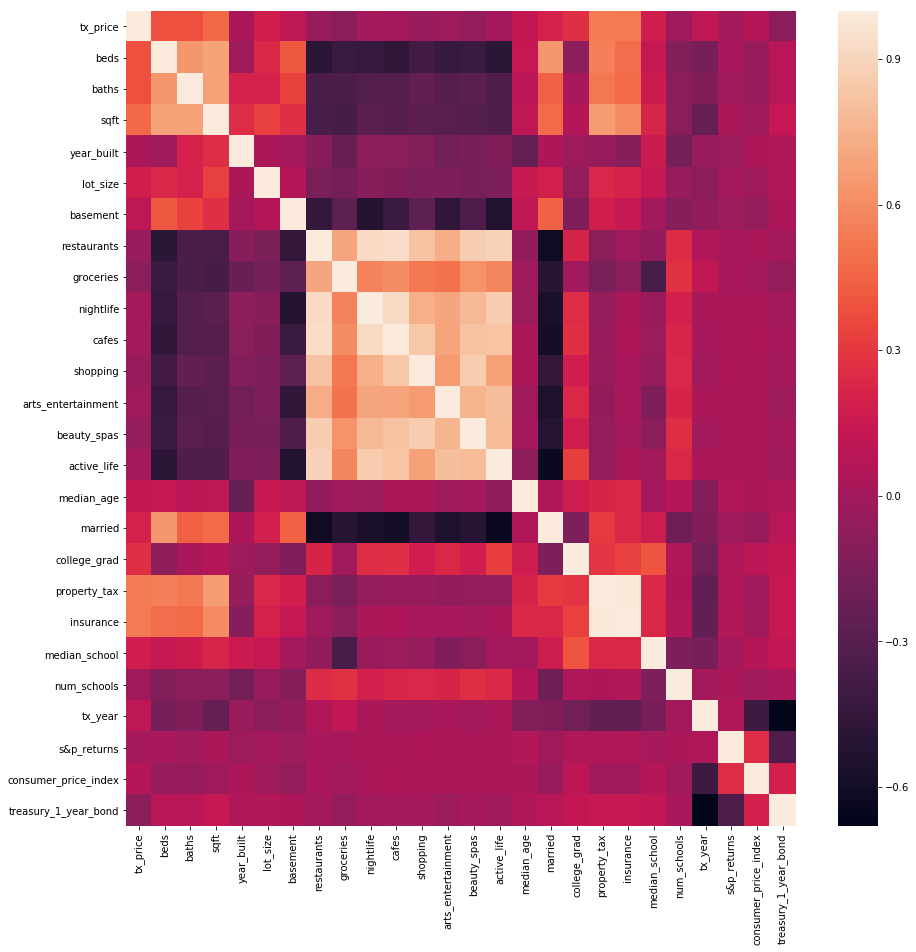

In [47]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr())

plt.savefig('images/heatmap1.png')

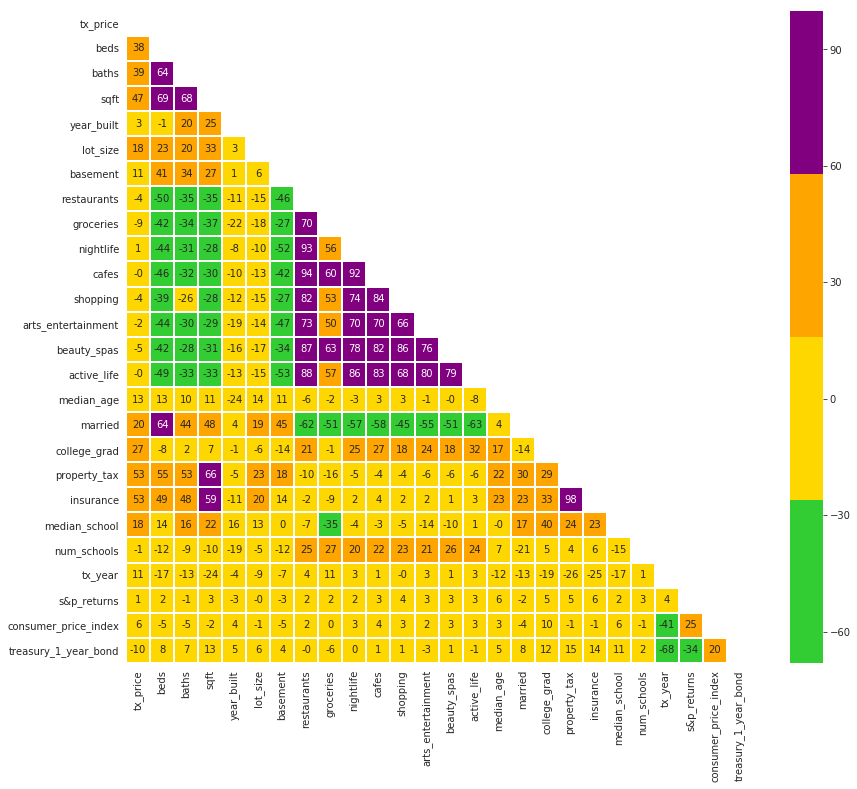

In [53]:
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14,12))
with sns.axes_style("white"):
    ax = sns.heatmap(df.corr()*100, mask=mask, fmt='.0f', annot=True, lw=1, cmap=ListedColormap(['limegreen', 'gold', 'orange','purple']))

In [32]:
# Save cleaned dataframe to new file
df.to_csv('Files/stock_df.csv', index=None)